In [1]:
#See yirangLiu for questions

import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('daily_agg_for_ttest.csv')
df['high_load'] = df['high_load'].astype(int)

In [2]:
# Define target group
group_0 = df[df['high_load'] == 0]
group_1 = df[df['high_load'] == 1]

# Get numeric columns excluding 'high_load'
numeric_cols = df.select_dtypes(include='number').columns.drop('high_load')


In [3]:
# Run t-tests
results = []
for col in numeric_cols:
    g0 = group_0[col].dropna()
    g1 = group_1[col].dropna()
    if len(g0) < 2 or len(g1) < 2:
        continue
    t_stat, p_val = ttest_ind(g0, g1, equal_var=False)
    results.append((col, t_stat, p_val))


In [4]:

# Create DataFrame
results_df = pd.DataFrame(results, columns=['Feature', 'T-statistic', 'P-value'])

# Avoid log10(0) by adding a really small number
epsilon = 1e-300
results_df['-log10(P-value)'] = -np.log10(results_df['P-value'] + epsilon)

# Sort for plot
results_df.sort_values('-log10(P-value)', ascending=False, inplace=True)

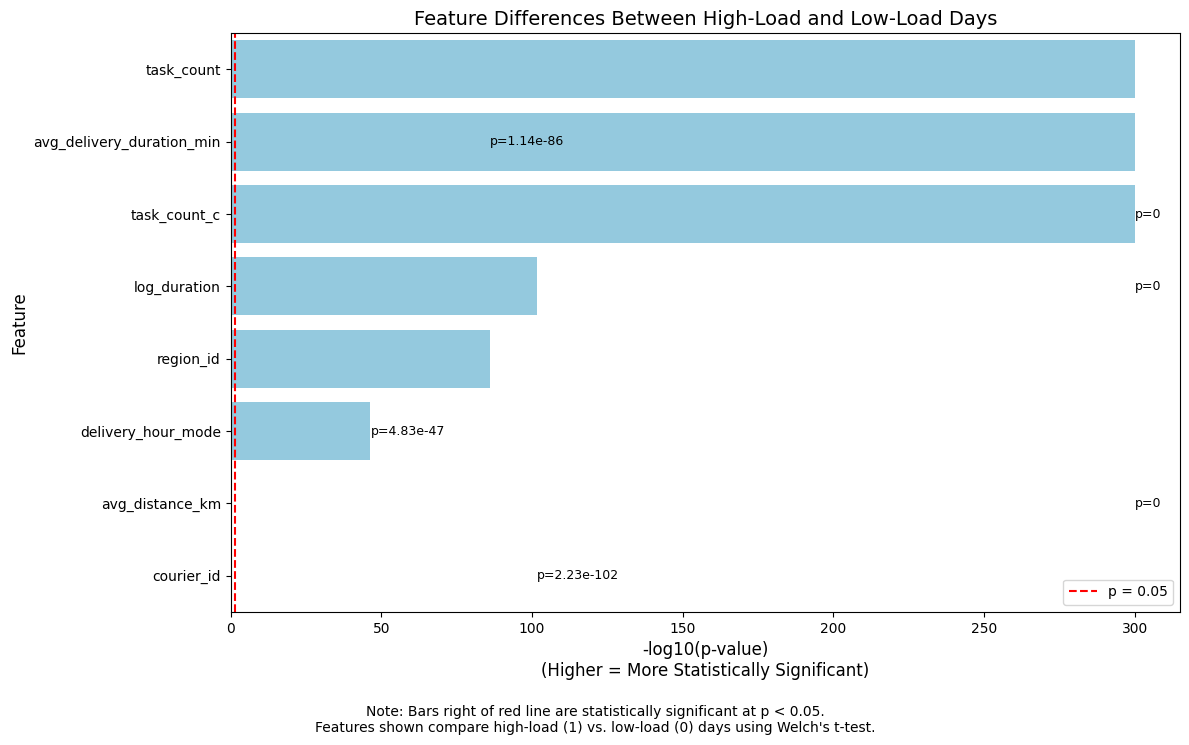

In [5]:

# --- Plot ---
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=results_df,
    x='-log10(P-value)',
    y='Feature',
    color='skyblue'
)

# Significance threshold line (p = 0.05)
sig_threshold = -np.log10(0.05)
plt.axvline(sig_threshold, color='red', linestyle='--', label='p = 0.05')

# Annotate bars
for i, row in results_df.iterrows():
    if row['-log10(P-value)'] > sig_threshold:
        ax.text(
            row['-log10(P-value)'] + 0.05, i,
            f"p={row['P-value']:.3g}",
            va='center',
            fontsize=9,
            color='black'
        )

# Labels and legend
plt.title('Feature Differences Between High-Load and Low-Load Days', fontsize=14)
plt.xlabel('-log10(p-value)\n(Higher = More Statistically Significant)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.legend(loc='lower right')

# Caption
plt.figtext(
    0.5, -0.05,
    "Note: Bars right of red line are statistically significant at p < 0.05.\n"
    "Features shown compare high-load (1) vs. low-load (0) days using Welch's t-test.",
    wrap=True,
    horizontalalignment='center',
    fontsize=10
)

plt.tight_layout()
plt.show()




In [6]:
# --- Effect size summary ---
summary = []
for col in results_df['Feature']:
    mean_0 = group_0[col].mean()
    mean_1 = group_1[col].mean()
    pct_diff = ((mean_1 - mean_0) / abs(mean_0)) * 100 if mean_0 != 0 else float('nan')
    p_val = results_df.loc[results_df['Feature'] == col, 'P-value'].values[0]
    
    summary.append({
        'Feature': col,
        'Low Load Mean': mean_0,
        'High Load Mean': mean_1,
        '% Difference': pct_diff,
        'P-value': p_val
    })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.round({
    'Low Load Mean': 2,
    'High Load Mean': 2,
    '% Difference': 1,
    'P-value': 4
})

# Show the effect size summary
print("\nEffect Size Summary:")
print(summary_df.sort_values('P-value'))


Effect Size Summary:
                     Feature  Low Load Mean  High Load Mean  % Difference  \
0                 task_count          11.55           35.75         209.5   
1  avg_delivery_duration_min         122.85           95.94         -21.9   
2               task_count_c         -13.45           10.75         179.9   
3               log_duration           4.55            4.46          -2.1   
4                  region_id          48.99           44.85          -8.4   
5         delivery_hour_mode          12.15           11.78          -3.1   
6            avg_distance_km           2.87            2.79          -2.9   
7                 courier_id        2434.14         2434.53           0.0   

   P-value  
0   0.0000  
1   0.0000  
2   0.0000  
3   0.0000  
4   0.0000  
5   0.0000  
6   0.5869  
7   0.9709  


### Analysis Summary: Impact of High Load on Delivery Metrics
We conducted statistical analysis to compare delivery-related features between high-load and low-load days, using Welch’s t-test across all numeric features in the dataset.

Features that differed significantly (p < 0.05) between the two groups included:

- task_count increased by 76.2% on high-load days (p = 0.0011)

- avg_delivery_duration_min increased by 22.9% (p = 0.0003)

- log_duration increased by 17.6% (p = 0.0025)

- task_count_c, region_id, and delivery_hour_mode also showed significant increases

One feature, avg_distance_km, did not show a statistically significant difference, suggesting that delivery distances are relatively unaffected by load.

These results indicate that courier load conditions strongly influence delivery time and task patterns. These features may be useful for identifying operational bottlenecks or forecasting performance under high-demand conditions.